# The Very Best Model
### Combined warbler acoustic parameters and audio descriptors on gradient boosted trees

In [1]:
import sklearn
import numpy as np
import pandas as pd
import xgboost as xg
import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline  

Load both data sets

In [2]:
descriptors_path = '/home/tracek/Data/gender/gender_descriptors.csv'
warbler_path = '/home/tracek/Data/gender/gender_warbler.csv'
seed = 42

params = {'max_depth': 13,
          'n_estimators': 1000,
          'objective': 'binary:logistic',
          'eval_metric': ['auc', 'error'],
          'gamma': 0.1}

test_fraction = 0.1
val_fraction = 0.2

Concatenate the two. Since they were produced on identical data sets and nothing is missing, we can simply sort data by filename and concatenate horizontally - no joins required.

In [3]:
warbler_df = pd.read_csv(warbler_path).sort_values('filename').drop(['filename', 'centroid', 'dfrange'], axis=1)
descriptors_df = pd.read_csv(descriptors_path).sort_values('filename').drop(['filename', 'label'], axis=1)
data = pd.concat([warbler_df, descriptors_df], axis=1)
y = data.pop('label')

### Train - Validation (Development) - Test split
I divide my data into three sets to prevent information leakage when tuning any hyperparameters.

In [4]:
if test_fraction > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_fraction, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_fraction, random_state=seed, stratify=y_train)
    dtest = xg.DMatrix(X_test, label=y_test)
else:
    X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=val_fraction, random_state=seed, stratify=y)

## Train! 

In [5]:
dtrain = xg.DMatrix(X_train, label=y_train)
dval = xg.DMatrix(X_val, label=y_val)
evallist = [(dval, 'eval'), (dtrain, 'train')]
model = xg.train(params=params, dtrain=dtrain, num_boost_round=100, evals=evallist, early_stopping_rounds=5)

[0]	eval-auc:0.990664	eval-error:0.022722	train-auc:0.993535	train-error:0.009527
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[1]	eval-auc:0.992364	eval-error:0.019645	train-auc:0.995143	train-error:0.007486
[2]	eval-auc:0.992999	eval-error:0.017751	train-auc:0.995605	train-error:0.005562
[3]	eval-auc:0.995294	eval-error:0.017041	train-auc:0.997063	train-error:0.004823
[4]	eval-auc:0.996245	eval-error:0.016805	train-auc:0.99868	train-error:0.003965
[5]	eval-auc:0.996757	eval-error:0.015385	train-auc:0.998968	train-error:0.003417
[6]	eval-auc:0.997089	eval-error:0.015444	train-auc:0.999565	train-error:0.00284
[7]	eval-auc:0.997237	eval-error:0.01503	train-auc:0.999762	train-error:0.002308
[8]	eval-auc:0.997232	eval-error:0.01432	train-auc:0.999877	train-error:0.002012
[9]	eval-auc:0.997403	eval-error:0.01355	train-auc:0.999932	train-error:0.001642
[10]	eval-auc:0.997594	eval-error:0.013

Looks great, beats the two separately (no surprises here). The model converges significantly faster then warbler alone and only a bit slower than descriptors alone. Yay.

In [6]:
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

In [7]:
r = metrics.classification_report(y_true=y_test, y_pred=y_pred)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [8]:
print(r)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      7882
          1       0.98      0.97      0.97      1507

avg / total       0.99      0.99      0.99      9389



In [9]:
print('Accuracy: ', acc)

Accuracy:  0.991692406007


### Excellent
The score on test set beats significantly the warbler and improves over descriptors alone.

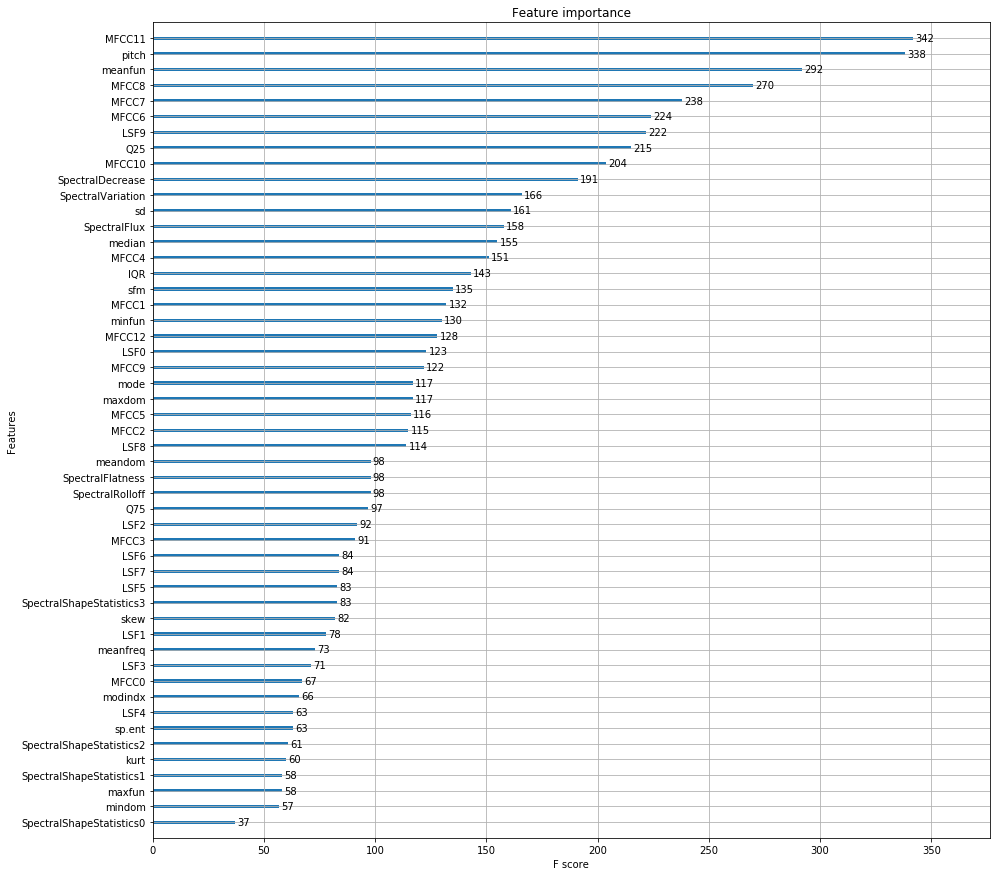

In [10]:
model.feature_names = [name.replace(' ', '') for name in model.feature_names]
fig, ax = plt.subplots(figsize=(15, 15))
xg.plot_importance(model, ax)

What is striking is that the pitch I am calculating (with aubio!) beats what warbleR delivers. Also, somewhat less surprisingly, mel-frequencies cepstrum coefficients are doing amazingly well. Curious, since aggregated I did not think they will be THAT informative (at least some). On the other hand, these are meant to capture voice characteristic.

Let's see how these features correlate with each other.

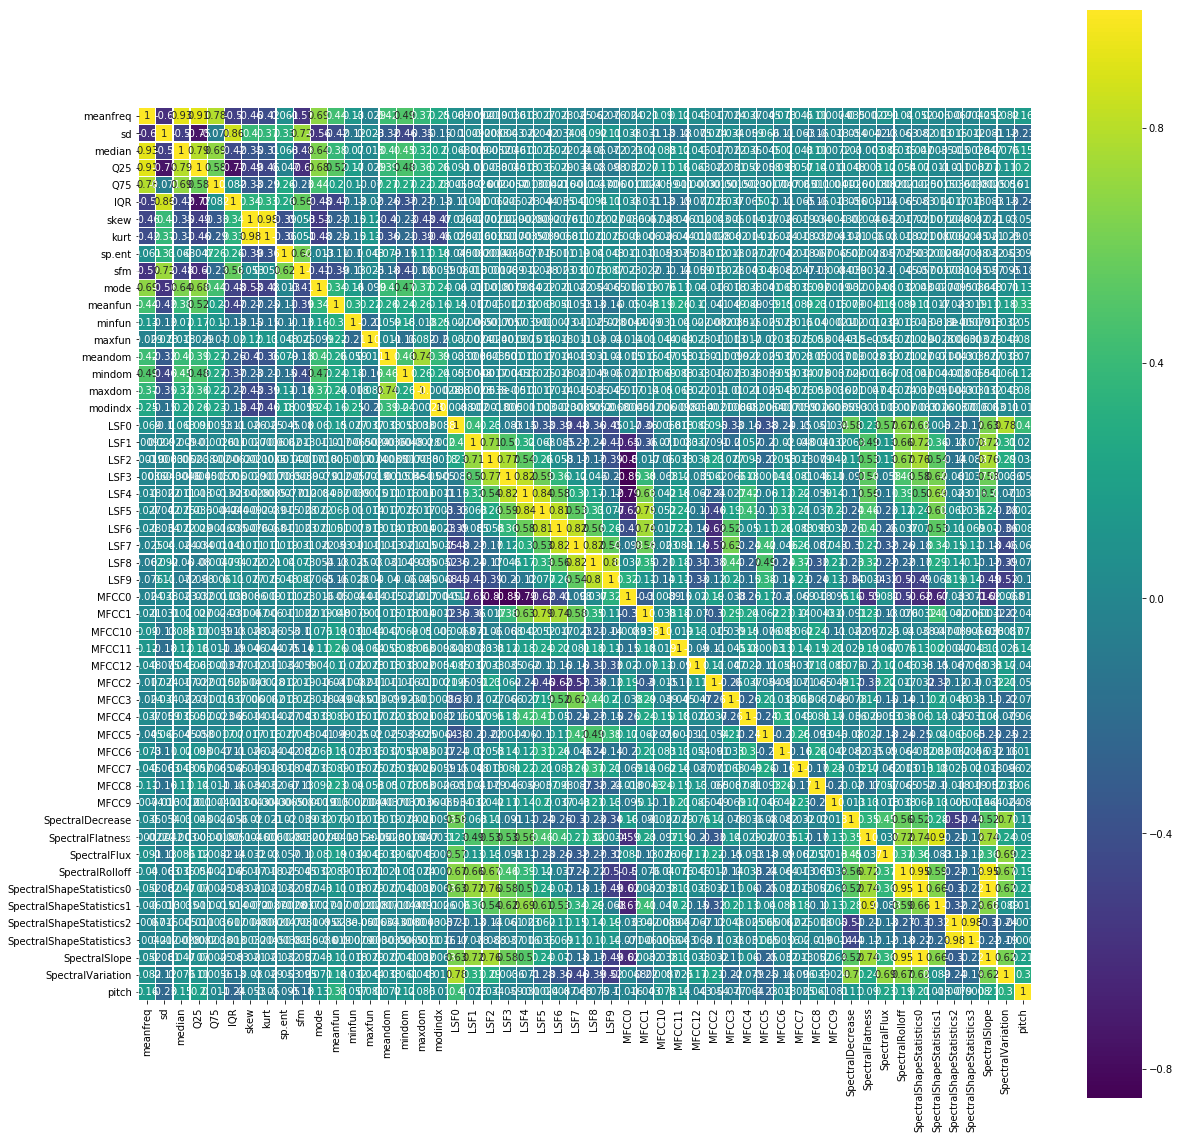

In [11]:
data_corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(data_corr, 
            xticklabels=data_corr.columns.values,
            yticklabels=data_corr.columns.values,
            linewidths=0.2,
            vmax=1.0,
            square=True,
            cmap=plt.cm.viridis,
            linecolor='white',
            annot=True)
plt.savefig('combined_correlation.png')

Interestingly, we don't get that high correlation on features that were computed from both approaches, like e.g. spectral flatness. 

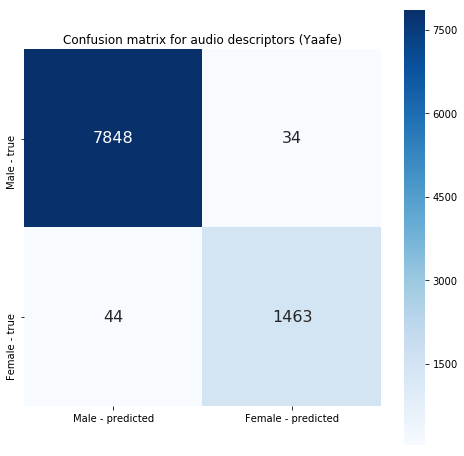

In [12]:
plt.figure(figsize=(8, 8))
plt.title('Confusion matrix for audio descriptors (Yaafe)')
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g', square=True,
            xticklabels=['Male - predicted', 'Female - predicted'], yticklabels=['Male - true', 'Female - true'])

## Discussion of errors
The mistakes are truly marginal. Model does not represent any strong bias. Frankly, I would easily confuse 1% of time a person on a phone. On top of that, the data set contains also recording of youth, meaning also people before voice change - or ongoing change. This will also confuse the model. Last, but not least...

# Data lies! 
(mo surprises here)
Here are two examples of incorrectly labelled recordings: *male* labelled as *female*:
- Anniepoo-20140308-bft - male
- abc-20091120-mfr - male